<a href="https://colab.research.google.com/github/prcstak/service_text_recognition/blob/main/notebooks/segmentation_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

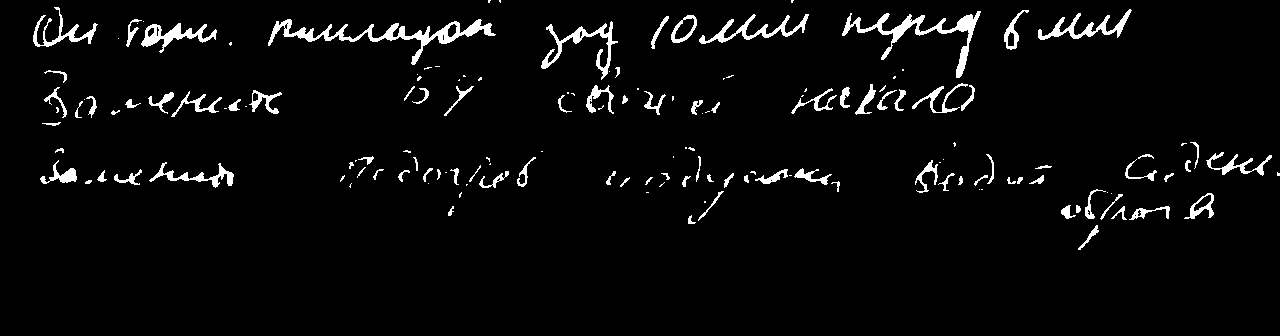

In [120]:
image = cv2.imread("/content/photo_2024-04-05_14-43-28.jpg")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(image,(5,5),0)
binarized_image = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
cv2_imshow(binarized_image)

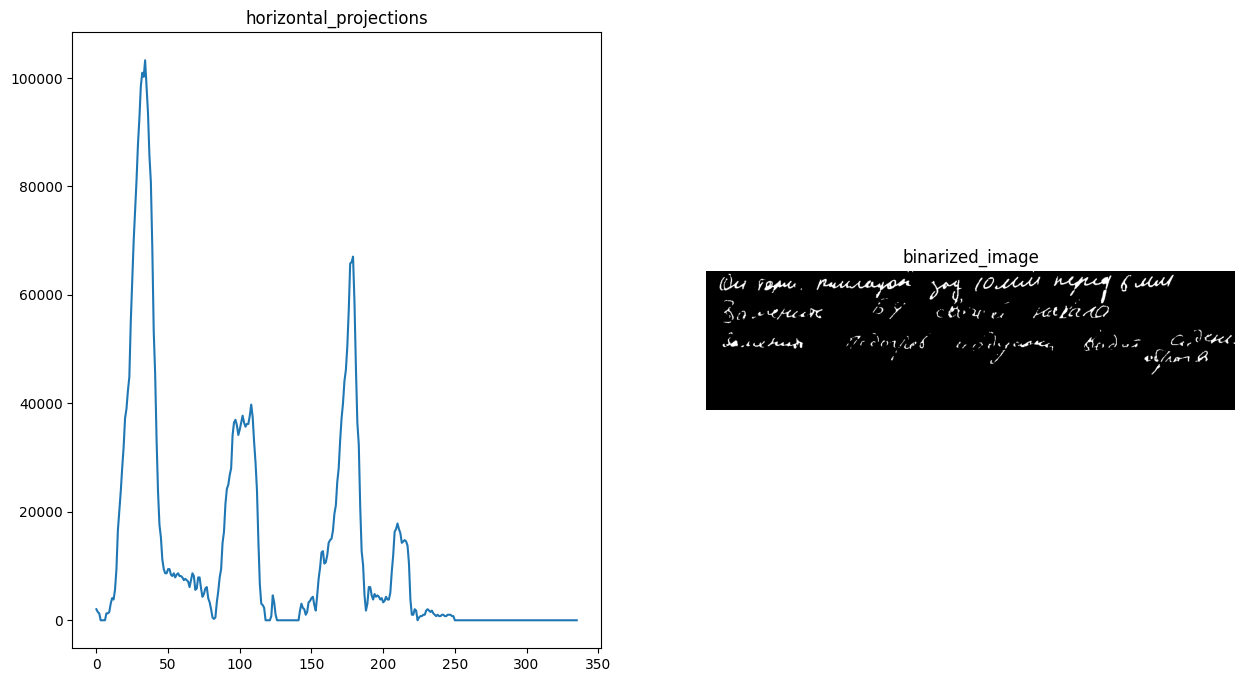

In [121]:
hpp = np.sum(binarized_image, axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()

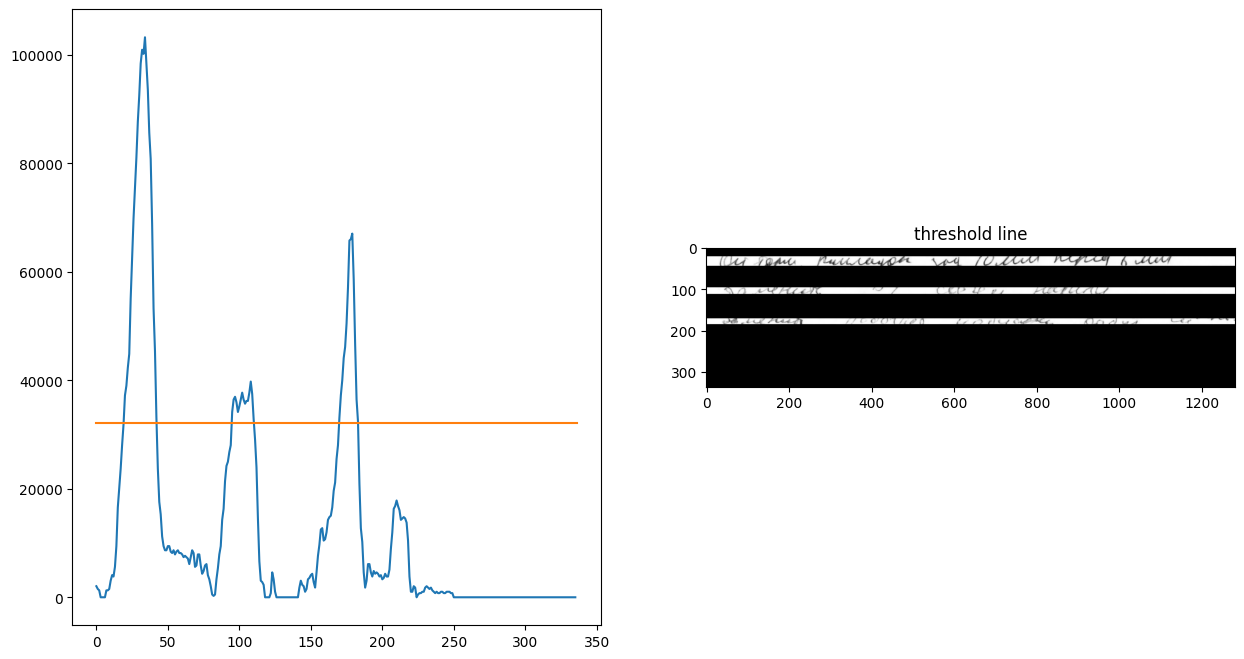

In [122]:
threshold = (np.mean(hpp)+((np.max(hpp)-np.min(hpp))/2))/2

peaks = []
for i, hppv in enumerate(hpp):
    if hppv < threshold:
        peaks.append([i, hppv])


peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(gray)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, image.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()


In [123]:
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 4


<ipython-input-124-70db03309387>:7: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[index].imshow(sub_image, cmap="gray")


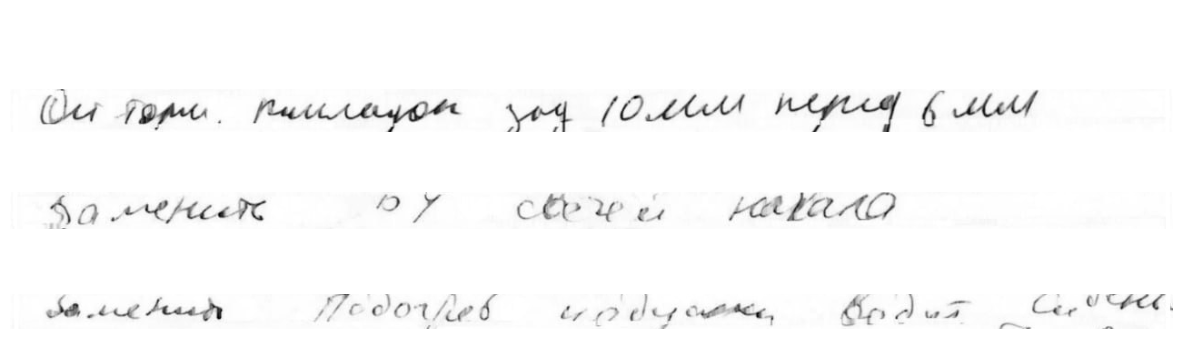

In [124]:
seperated_images = []
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,5))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = gray[sub_image_index[0]-12:sub_image_index[1]+12]
    seperated_images.append(sub_image)
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

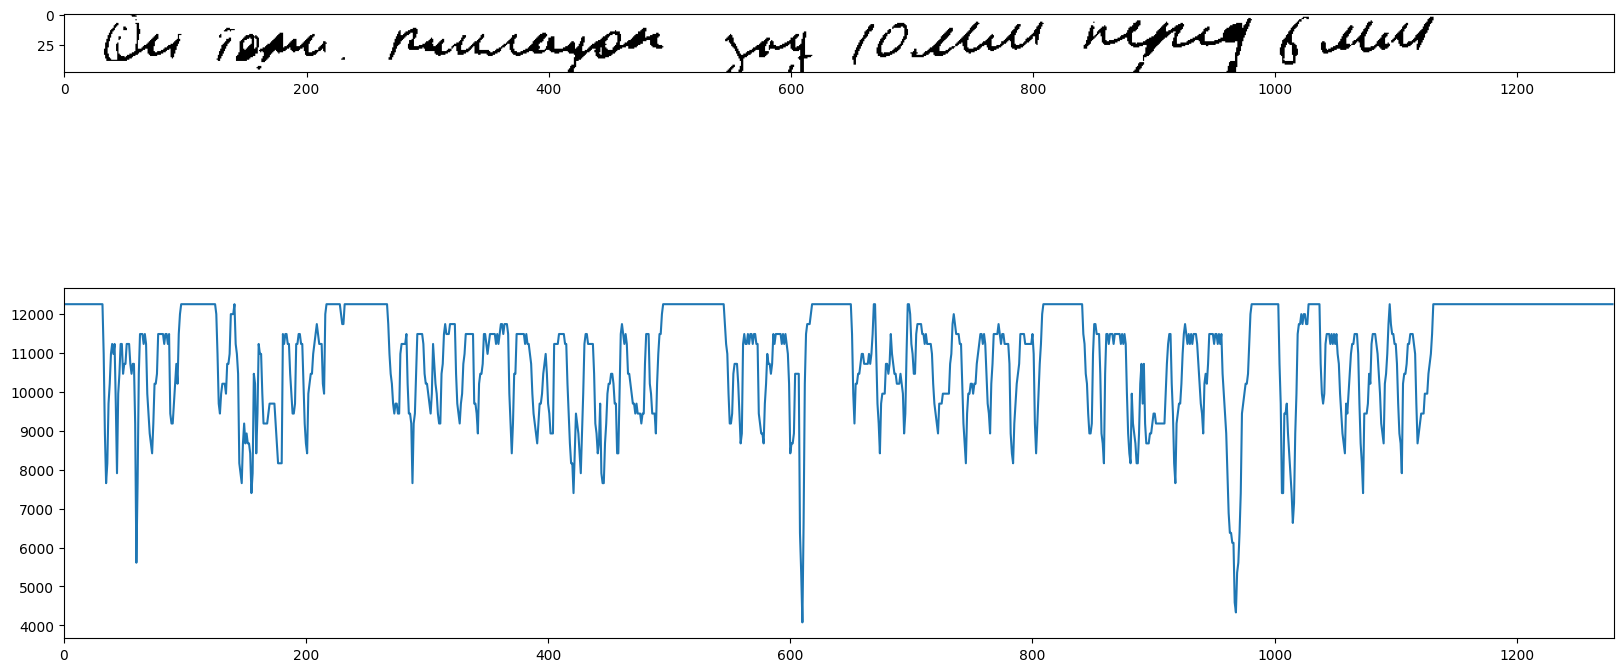

In [127]:
first_line = seperated_images[1]
binary = cv2.threshold(first_line,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# find the vertical projection by adding up the values of all pixels along rows
vertical_projection = np.sum(binary, axis=0)

# plot the vertical projects
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
plt.xlim(0, first_line.shape[1])
ax[0].imshow(binary, cmap="gray")
ax[1].plot(vertical_projection)

In [128]:
height =  vertical_projection.max()#first_line.shape[0]
print(vertical_projection.max())
## we will go through the vertical projections and
## find the sequence of consecutive white spaces in the image
whitespace_lengths = []
whitespace = 0
for vp in vertical_projection:
    if vp == height:
        whitespace = whitespace + 1
    elif vp != height:
        if whitespace != 0:
            whitespace_lengths.append(whitespace)
        whitespace = 0 # reset whitepsace counter.

print("whitespaces:", whitespace_lengths)
avg_white_space_length = np.mean(whitespace_lengths)
print("average whitespace lenght:", avg_white_space_length)

12240
whitespaces: [33, 29, 1, 12, 36, 51, 33, 2, 2, 33, 23, 10, 1]
average whitespace lenght: 20.46153846153846


In [129]:
## find index of whitespaces which are actually long spaces using the avg_white_space_length
whitespace_length = 0
divider_indexes = []
for index, vp in enumerate(vertical_projection):
    if vp == height:
        whitespace_length = whitespace_length + 1
    elif vp != height:
        if whitespace_length != 0 and whitespace_length > avg_white_space_length:
            divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it

print(divider_indexes)

[17, 112, 244, 521, 635, 824, 993]


In [130]:
# lets create the block of words from divider_indexes
divider_indexes = np.array(divider_indexes)
dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))

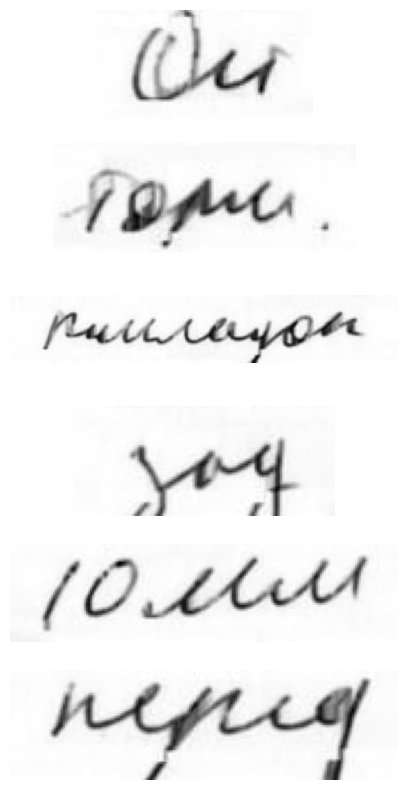

In [131]:
# now plot the findings
fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
words = []
for index, window in enumerate(dividers):
    ax[index].axis("off")
    word = first_line[:,window[0]:window[1]]
    ax[index].imshow(word, cmap="gray")
    words.append(word)